# Hyperparameter Tuning Example: ANN on MNIST with GPyOpt

Having explored the theoretical underpinnings of Bayesian Optimization (BO) and introduced key libraries, let’s now dive into a practical example: tuning hyperparameters for an Artificial Neural Network (ANN) using **GPyOpt**. We’ll use the MNIST dataset, a standard benchmark for digit classification featuring 28×28 grayscale images across 10 classes. Our focus is on optimizing the learning rate $\alpha$ and batch size $s$ of an ANN to maximize validation accuracy, demonstrating BO’s ability to efficiently navigate the hyperparameter space for a real-world task.

---
## Setup and Objective

We leverage the MNIST dataset, consisting of 60,000 training images and 10,000 test images, which we preprocess by normalizing pixel values to [0, 1] and splitting the training set into 48,000 training and 12,000 validation samples. The ANN is a simple feedforward network with two hidden layers (128 and 64 units) and a softmax output layer for classification. Our goal is to maximize the validation accuracy, treated as a black-box function $f(\mathbf{x})$, where $\mathbf{x} = [\alpha, s]$. GPyOpt employs a Gaussian Process (GP) to model this function and the Expected Improvement (EI) acquisition function to select hyperparameter sets:
$$\mathrm{EI}(\mathbf{x}) = \mathbb{E} \left[ \max(f(\mathbf{x}) - f(\mathbf{x}^+), 0) \mid \mathcal{D}_{1:t-1} \right].$$

The hyperparameters to tune are:
- **Learning rate** ($\alpha \in [0.0001, 0.1]$): Controls the step size of the Adam optimizer during gradient descent.
- **Batch size** ($s \in \{32, 64, 128, 256\}$): Number of samples processed per training iteration, chosen as discrete values to balance computation and convergence.

---
## Code Implementation
We optimize two ANN hyperparameters—learning rate and batch size—using `GPyOpt` with a GP surrogate and EI acquisition function. The process involves:
1. Loading and preprocessing the MNIST data.
2. Defining the ANN architecture and objective function (negative validation accuracy).
3. Setting the hyperparameter search space.
4. Running BO with 10 initial random points and 20 iterations.
5. Visualizing initial evaluations, convergence, and final model performance on the test set.

In [48]:
## Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from GPyOpt.methods import BayesianOptimization
import GPyOpt

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [90]:
# Load and Preprocess the MNIST Dataset
# Load MNIST dataset
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to [0, 1]
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Split training data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=42)

# Reshape data for ANN (flatten 28x28 images into 784-dimensional vectors)
x_train = x_train.reshape(-1, 28*28)
x_val = x_val.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_val.shape}")
print(f"Test data shape: {x_test.shape}")

Training data shape: (48000, 784)
Validation data shape: (12000, 784)
Test data shape: (10000, 784)


In [132]:
# Define the ANN Model and Objective Function
def build_ann(learning_rate):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(784,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def objective_function(params):
    # Extract hyperparameters from GPyOpt params (2D array: [[learning_rate, batch_size]])
    learning_rate = params[0, 0]
    batch_size = int(params[0, 1])  # Batch size must be an integer
    
    # Build and train the ANN
    model = build_ann(learning_rate)
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=5, 
                        validation_data=(x_val, y_val), verbose=0)
    
    # Get validation accuracy (maximize this, so return negative loss for minimization)
    val_accuracy = history.history['val_accuracy'][-1]
    return -val_accuracy  # GPyOpt minimizes, so negate accuracy

print('************Finish building the ANN Model and Objective Function************')

************Finish building the ANN Model and Objective Function************


In [134]:
# Define the Search Space
# Define hyperparameter bounds: learning_rate and batch_size
bounds = [
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.0001, 0.1)},  # Range for learning rate
    {'name': 'batch_size', 'type': 'discrete', 'domain': (32, 64, 128, 256)}   # Discrete batch sizes
]
print('************Finish defining the Search Space************')

************Finish defining the Search Space************


In [136]:
# Initialize and Run Bayesian Optimization
# Initialize BO with GPyOpt
optimizer = BayesianOptimization(
    f=objective_function,          # Objective function to minimize
    domain=bounds,                 # Hyperparameter search space
    model_type='GP',               # Gaussian Process surrogate
    acquisition_type='EI',         # Maximum Probability of Improvement (MPI)
    maximize=False,                # Minimize the objective (negative accuracy)
    initial_design_numdata=10,     # Number of initial random points
    max_iter=20                    # Number of BO iterations after initial points
)

# Run the optimization
optimizer.run_optimization()
print('************Runing Bayesian Optimization************')


************Runing Bayesian Optimization************


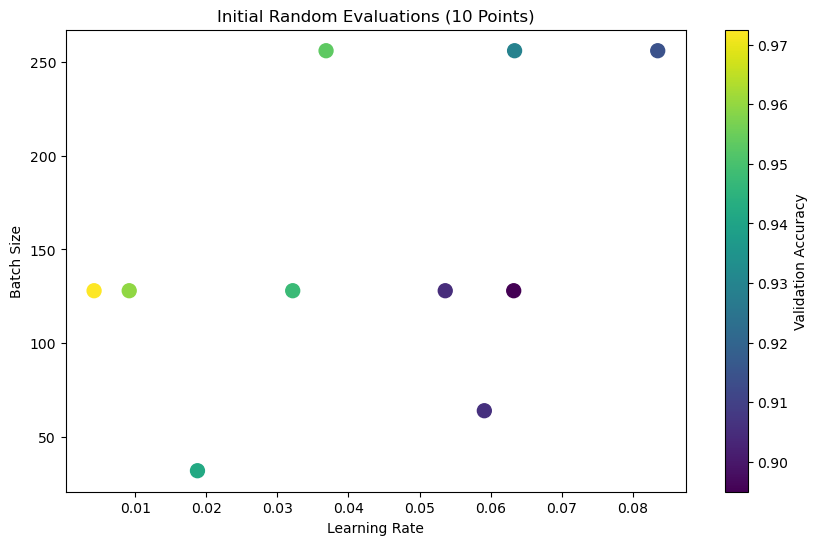

In [124]:
#  Plot Initial Random Evaluations
# Extract initial points and their evaluations
initial_X = optimizer.X[:10]  # First 5 points are initial random samples
initial_Y = optimizer.Y[:10]

plt.figure(figsize=(10, 6))
plt.scatter(initial_X[:, 0], initial_X[:, 1], c=-initial_Y.flatten(), cmap='viridis', s=100)
plt.colorbar(label='Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Batch Size')
plt.title('Initial Random Evaluations (10 Points)')
plt.show()

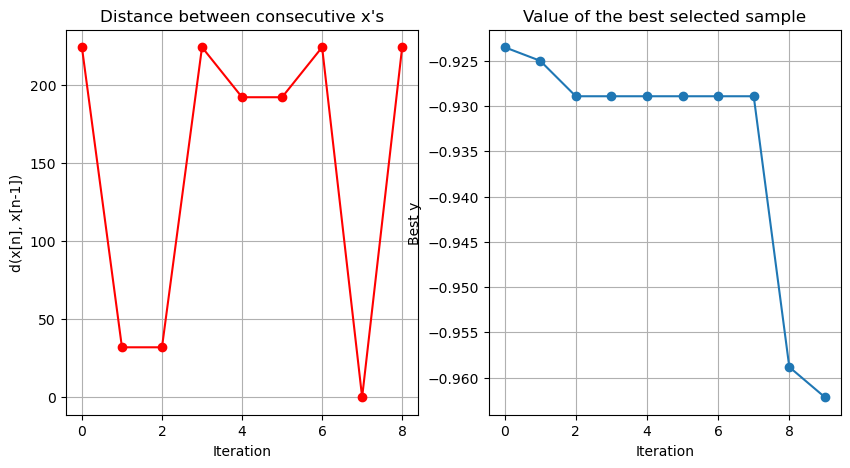

In [145]:
# Plot Convergence
# Plot the convergence of the optimization process
optimizer.plot_convergence()
plt.show()

In [128]:

# Report Optimal Hyperparameters and Evaluate on Test Set
optimal_learning_rate = optimizer.x_opt[0]
optimal_batch_size = int(optimizer.x_opt[1])
print(f"Optimal Learning Rate: {optimal_learning_rate:.5f}")
print(f"Optimal Batch Size: {optimal_batch_size}")
print(f"Best Validation Accuracy: {-optimizer.fx_opt:.4f}")

# Train final model with optimal hyperparameters and capture history
final_model = build_ann(optimal_learning_rate)
history = final_model.fit(x_train, y_train, batch_size=optimal_batch_size, epochs=5, 
                         validation_data=(x_val, y_val), verbose=1)  # Capture history here
test_loss, test_accuracy = final_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy with Optimal Hyperparameters: {test_accuracy:.4f}")

Optimal Learning Rate: 0.00417
Optimal Batch Size: 128
Best Validation Accuracy: 0.9725
Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8677 - loss: 0.4410 - val_accuracy: 0.9563 - val_loss: 0.1393
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9641 - loss: 0.1190 - val_accuracy: 0.9615 - val_loss: 0.1243
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9741 - loss: 0.0855 - val_accuracy: 0.9645 - val_loss: 0.1191
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9802 - loss: 0.0646 - val_accuracy: 0.9643 - val_loss: 0.1252
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9828 - loss: 0.0543 - val_accuracy: 0.9709 - val_loss: 0.1135
Test Accuracy with Optimal Hyperparameters: 0.9713


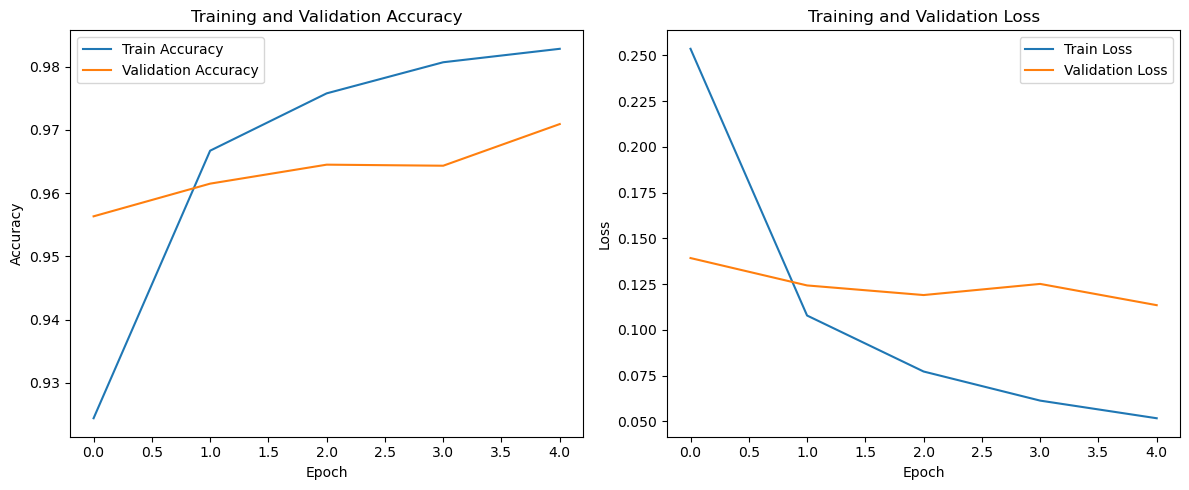

In [130]:
# Plot Training History of Final Model
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()